In [1]:
from functools import partial
import numpy as np
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc, animation

%matplotlib notebook

###############################################################################
# Plot initialization

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8,
          'font.size': 8,
          'legend.fontsize': 6,
          'text.usetex': True,
          'figure.figsize': (6, 4)}
plt.rcParams.update(params)


In [2]:
dirname = "../prebuiltimages/"
imageformat = ".pdf"  # should be .pdf or .png    
# some colors I'll use
brown = (0.64, 0.16, 0.16)
purple = (148. / 255, 0, 211. / 255)
plt.close("all")
# saving = True
saving = False

In [3]:
# sns.set_context("poster")
sns.set_style("ticks")
color_blind_list = sns.color_palette("colorblind", 8)
sns.set_palette("colorblind")
my_blue = color_blind_list[0]

In [4]:
###############################################################################
# Setup for functions


def ori_function(x):
    """Define a 1D function f (whose f** will be displayed)."""
    gauss_pdf = np.exp(-(x - 6.) ** 2 / 2.) / np.sqrt(2. * np.pi)
    return 0.5 * (x - 3) ** 2. + 100. + 100. * gauss_pdf


def absolute_value(x):
    """Absolute value function"""
    return 3 * np.abs(x)


def BerHu(x):
    """BerHu f (whose f** will be displayed)."""
    L = 15
    z = np.abs(x)
    if isinstance(x, np.ndarray):
        j = np.abs(x) > L
        z[j] = (x[j] ** 2 + L ** 2) / (2 * L)
    else:
        if np.abs(x) > L:
            z = (x ** 2 + L ** 2) / (2 * L)
    return 3 * z


def huber_ori(x, threshold=2.5):
    """Original Huber function."""


def Huber(x):
    threshold = 40
    x = x * 20 # Display hack
    x = np.atleast_1d(x)
    z = x ** 2 / (2 * threshold)
    test = np.abs(x) > threshold
    z[test] = np.abs(x)[test] - threshold / 2
    return z 


def trans2infty(x, precision_infty=10000):
    """Inf-clipping to handle minimization numerical issues."""
    if not(np.isfinite(x)) or np.abs(x) > precision_infty:
        z = np.inf
    else:
        z = x
    return z

In [5]:
def partial_function(s, x):
    """1D function be used for conjugate definitions."""
    if isinstance(x, np.ndarray):
        z = np.repeat(np.nan, x.shape)
        j = np.isfinite(x)
        z[j] = func_to_plot(x[j]) - x[j] * s
    else:
        if np.isfinite(x):
            z = func_to_plot(x) - x * s
        else:
            z = np.nan
    return z

<IPython.core.display.Javascript object>


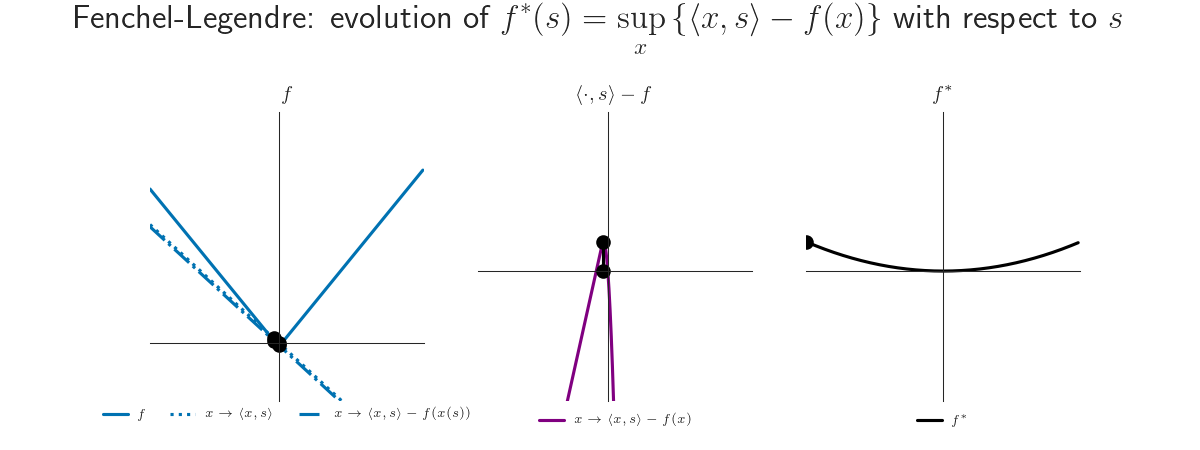

In [6]:
###############################################################################
# Setup figure and subplots

# func_to_plot = Huber
# func_to_plot = absolute_value
# func_to_plot = BerHu
func_to_plot = ori_function

func_name = func_to_plot.__name__


x_min = - 40.
x_max = 45.
x = x_min
x_tab = np.arange(x_min, x_max, step=0.2)

# init: s value
s = -15.
s_min = s
s_max = 15
s_step = 0.2
s_grid = np.arange(s_min, s_max, step=s_step)
nb_s = len(s_grid)


fun_val = func_to_plot(x_tab)
ymax = np.max(fun_val)
ymin = np.min(fun_val)

lin_val = x_tab * s
dual_fun_val = func_to_plot(x_tab)

initial_opt = 6.001   # thumb rule : start around the "hill" for the 1st func, Huber
# initial_opt = 0.000000001   # thumb rule : start around the "hill" for the BerHu and Abs


to_opt = partial(partial_function, s)
x_opt = (minimize(to_opt, initial_opt, method='BFGS').x[0])

list_s = np.zeros(0)
f_conj_val = np.zeros(0)

for i, s_index in enumerate(s_grid):
    to_opt_in = partial(partial_function, s_index)
    x_opt_in = minimize(to_opt_in, initial_opt, method='BFGS').x[0]
    f_conj_val = np.append(f_conj_val,
                           trans2infty(- partial_function(s_index, x_opt_in)))

ymin3 = np.min(f_conj_val)
ymax3 = np.max(f_conj_val)


f0 = plt.figure(num=0, figsize=(8, 3))  # dpi = 100)
ax01 = plt.subplot2grid((1, 3), (0, 0))
ax02 = plt.subplot2grid((1, 3), (0, 1))
ax03 = plt.subplot2grid((1, 3), (0, 2))
sns.despine(top=True, right=False, left=False, bottom=False)

title = 'fenchel_legendre' + func_name + '.mp4'

# Set titles of subplots
ax01.set_title(r"$f$")
ax02.set_title(r'$\langle \cdot,s \rangle - f$')
ax03.set_title('$f^*$')

f0.subplots_adjust(top=0.75)
f0.suptitle(r"Fenchel-Legendre: evolution of " +
            r"$\displaystyle f^{*}(s)= \sup_{x} \big\{ \langle x,s \rangle -f(x) \big\}$ with respect to $s$", 
            fontsize=16)


In [7]:
def prepare_ax(ax, y_min, y_max, x_min, x_max, x_label):
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data', 0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel(x_label)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)


In [8]:
###############################################################################
# Left plot
yrange = ymax - ymin
prepare_ax(ax01, y_min=ymin - yrange / 3., y_max=ymax + yrange / 3.,
           x_min=x_min, x_max=x_max, x_label=' ')



ax01.plot(x_tab, fun_val, '-', c=my_blue, label='$f$')
p011, = ax01.plot(x_tab, lin_val, ':', c=my_blue,
                  label=r'$x\to\langle x, s \rangle$')

lin_val_shifted = lin_val - partial_function(s, x_opt)
p0111, = ax01.plot(x_tab, lin_val_shifted, '-.', c=my_blue,
                   label=r'$x\to\langle x, s \rangle - f(x(s))$')

p012, = ax01.plot([x_opt, x_opt], [func_to_plot(x_opt), s * x_opt], 'ko-')
p0122, = ax01.plot([0, 0],
                   [0, trans2infty(- func_to_plot(x_opt) + s * x_opt)],
                   'ko-')
ax01.legend(loc='upper center', bbox_to_anchor=(0.50, 0.01),
            fancybox=True, shadow=True, ncol=3)


###############################################################################
# Middle plot

y2 = - partial_function(s, x_tab)

ymin2 = np.min(y2)
ymax2 = np.max(y2)

prepare_ax(ax02, y_min=ymin3 - 50., y_max=ymax3 + 50,
           x_min=x_min - 5., x_max=x_max + 5., x_label='')


p021, = ax02.plot(x_tab, y2, '-', c='purple',
                  label=r'$x\to\langle x, s \rangle-f(x)$')
p022, = ax02.plot([x_opt, x_opt], [0, -partial_function(s, x_opt)], 'ko-')

ax02.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),
            fancybox=True, shadow=True, ncol=5)

###############################################################################
# Right plot
prepare_ax(ax03, y_min=ymin3 - 50., y_max=ymax3 + 50,
           x_min=s_min, x_max=s_max, x_label='')


ax03.plot(s_grid, f_conj_val, 'k-', label=r'$f^*$')
p032, = ax03.plot(s, -partial_function(s, x_opt), 'ko-')
ax03.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),
            fancybox=True, shadow=True, ncol=5)


def update_data(nframe):
    """Updating step."""
    # global s
    global func_to_plot
    global list_s
    global f_conj_val
    global x_opt
    global s_step
    s = s_grid[nframe]

    # s += s_step
    list_s = np.append(list_s, s)
    to_opt = partial(partial_function, s)
    x_opt = trans2infty(minimize(to_opt, initial_opt, method='BFGS').x[0])

    # Plotting the dash lines in left subplot
    x_new = x_tab * s
    p011.set_data(x_tab.tolist(), x_new.tolist())
    vert_x = [x_opt, x_opt]
    vert_y = [func_to_plot(x_opt), s * x_opt]
    vert_y_bis = [0, trans2infty(partial_function(s, x_opt))]
    x_new = x_tab * s
    lin_val_shifted = x_new + partial_function(s, x_opt)
    p0111.set_data(x_tab, lin_val_shifted)

    # Plotting the black line/circle in left subplot
    p012.set_data(vert_x, vert_y)
    f_conj_val = np.append(f_conj_val, -partial_function(s, x_opt))
    p0122.set_data([0, 0], vert_y_bis)

    # Plotting the black line/circle in middle subplot
    p021.set_data(x_tab, - partial_function(s, x_tab))
    p022.set_data([x_opt, x_opt], [0, -partial_function(s, x_opt)])

    # Plotting the black line/circle in right subplot
    p032.set_data(s, -partial_function(s, x_opt))
    return p011, p012, p021, p032


Nframes = nb_s


def animate_as_gif(nframe):
    """Perform: Patrol-loop (otherwise just plug-in update_data)."""
    if nframe < Nframes:
        nframe = nframe
    elif nframe >= Nframes:
        nframe = 2 * Nframes - nframe - 1
    return update_data(nframe)


simulation = animation.FuncAnimation(f0, animate_as_gif, blit=False,
                                     frames=2 * nb_s,
                                     interval=20, repeat=False)


# to save the animation
if saving:
    simulation.save(title, dpi=400)
#     simulation.save('fenchel' + func_name + '.gif', writer='imagemagick')
plt.show()